## Time series analysis of gold price (MDS201803)

In [24]:
import warnings
warnings.filterwarnings("ignore")
import time
import plotly
import pyramid
import statsmodels
import numpy as np
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from arch.unitroot import PhillipsPerron
from pyramid.arima import auto_arima

In [25]:
data = pd.read_csv("/media/subhasish/Professional/CMI/Sem_3/Time_series/monthly_csv.csv")
train_data = data[336:750]
test_data = data[750:]

In [26]:
data.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [27]:
data.describe()

,Price
count,835.000000
mean,399.575729
std,433.827739
min,34.490000
25%,35.190000
50%,316.298000
75%,437.726500
max,1780.648000


In [28]:
train_data.head()

,Date,Price
336,1978-01,173.207
337,1978-02,178.360
338,1978-03,183.771
339,1978-04,175.323
340,1978-05,176.190


In [29]:
test_data.tail()

,Date,Price
830,2019-03,1302.286
831,2019-04,1287.650
832,2019-05,1282.460
833,2019-06,1358.488
834,2019-07,1414.611


In [30]:
fig = px.line(train_data, x='Date', y='Price')
fig.show()

### Decomposition of data

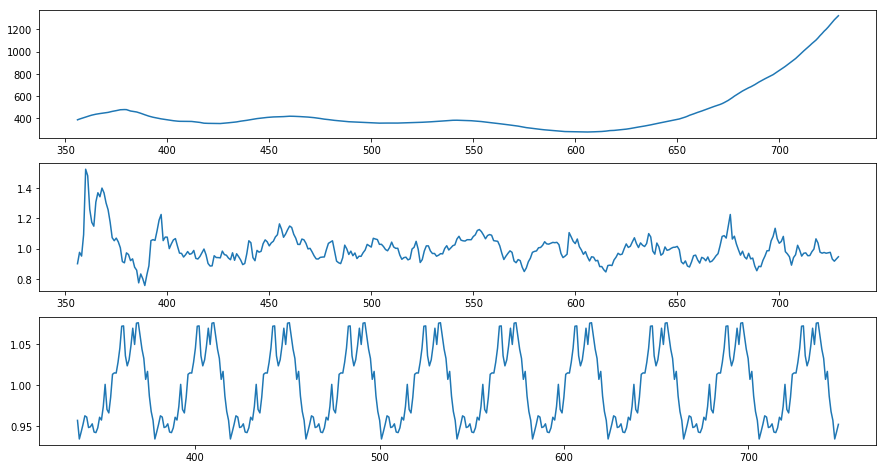

In [31]:
res = sm.tsa.seasonal_decompose(data["Price"][336:750],
                                freq=41,
                                model='multiplicative')
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1, y='Trend')
res.resid.plot(ax=ax2, y='Residual')
res.seasonal.plot(ax=ax3, y='Seasonal')

### Fitting a polynomial to the given data

In [32]:
x = np.arange(1,len(train_data)+1,1)
z = np.polyfit(x, train_data['Price'], 3)
p = np.poly1d(z)
train_data['fitted_values'] = p(x)

In [33]:
train_data.head()

,Date,Price,fitted_values
336,1978-01,173.207,198.797605
337,1978-02,178.360,205.928226
338,1978-03,183.771,212.946027
339,1978-04,175.323,219.851701
340,1978-05,176.190,226.645943


In [34]:
df_new = pd.DataFrame({'values' : list(train_data['Price'])+list(train_data['fitted_values']), 'type' : list(['price']*len(train_data)+["fitted_values"]*len(train_data))})
fig = px.line(df_new, y="values", color='type')
fig.show()

In [35]:
train_data['detrended'] = train_data['Price']-train_data["fitted_values"]

In [36]:
train_data.head()

,Date,Price,fitted_values,detrended
336,1978-01,173.207,198.797605,-25.590605
337,1978-02,178.360,205.928226,-27.568226
338,1978-03,183.771,212.946027,-29.175027
339,1978-04,175.323,219.851701,-44.528701
340,1978-05,176.190,226.645943,-50.455943


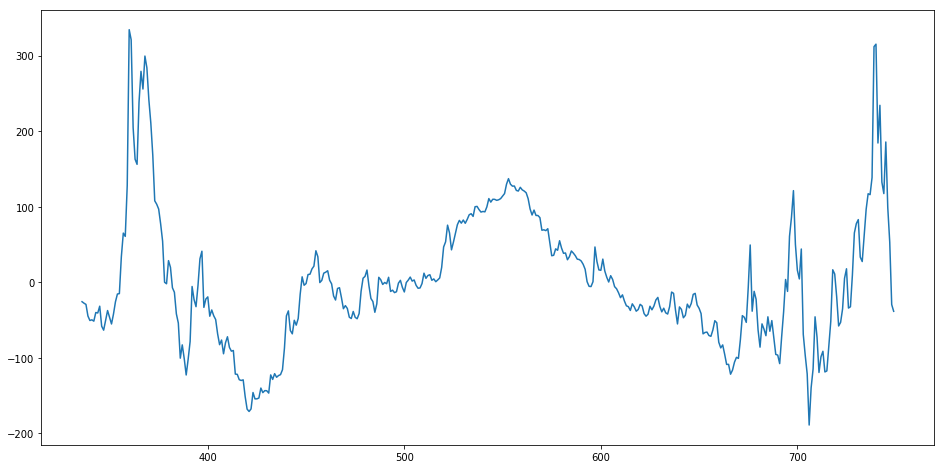

In [37]:
plt.figure(figsize=(16,8))
plt.plot(train_data['detrended'])
plt.show()

##  Defining stationarity test

In [38]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)
            
def KPSS_Test(self, timeseries, printResults = True):

        #KPSS test:
        kpsstest = kpss(timeseries, regression='c')
        
        self.pValue = kpsstest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = False
        else:
            self.isStationary = True
        
        if printResults:
            kpssResults = pd.Series(kpsstest[0:3], index=['KPSS Test Statistic','P-Value','# Lags Used'])

            #Add Critical Values
            for key,value in kpsstest[3].items():
                kpssResults['Critical Value (%s)'%key] = value

            print('KPSS Test Results:')
            print(kpssResults)
            



## Stationarity test results

In [39]:
sTest = StationarityTests()
ADF_Stationarity_Test(sTest,train_data['Price'], printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        1.719668
P-Value                   0.998176
# Lags Used              18.000000
# Observations Used     395.000000
Critical Value (1%)      -3.447014
Critical Value (5%)      -2.868885
Critical Value (10%)     -2.570683
dtype: float64
Is the time series stationary? False


In [40]:
sTest = StationarityTests()
KPSS_Test(sTest,train_data['Price'], printResults = True)
print("Is the time series stationary? {}".format(sTest.isStationary))

KPSS Test Results:
KPSS Test Statistic       0.940923
P-Value                   0.010000
# Lags Used              18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Is the time series stationary? False


In [41]:
pp = PhillipsPerron(train_data['Price'])
print(pp)

     Phillips-Perron Test (Z-tau)    
Test Statistic                  1.826
P-value                         0.998
Lags                               18
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## Plotting the ACF & PACF of the non-stationary data 

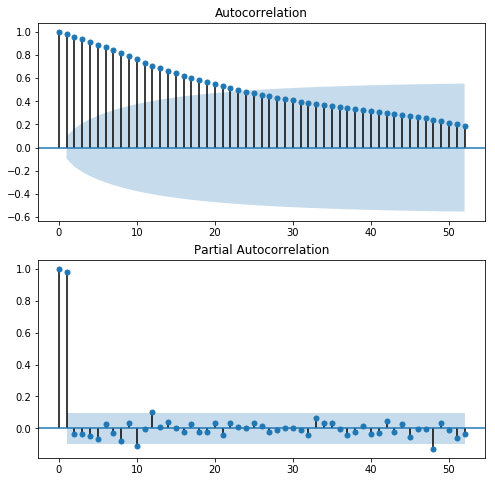

In [42]:
import statsmodels.api as sm
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_data['Price'], lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_data['Price'], lags=52, ax=ax2)
fig.show()

## Making the data stationary 

In [43]:
# taking log
train_data['log_price'] = np.log(train_data['Price'])
test_data['log_price'] = np.log(test_data['Price'])

In [44]:
# taking difference operator of order 1
train_data['lagprice'] = train_data['log_price'].shift(1)
train_data['D_1(price)'] = train_data['log_price']-train_data['lagprice']
train_data = train_data[1:]

test_data['lagprice'] = test_data['log_price'].shift(1)
test_data['D_1(price)'] = test_data['log_price']-test_data['lagprice']
test_data = test_data[1:]

In [45]:
train_data.head()

,Date,Price,fitted_values,detrended,log_price,lagprice,D_1(price)
337,1978-02,178.360,205.928226,-27.568226,5.183804,5.154487,0.029317
338,1978-03,183.771,212.946027,-29.175027,5.213690,5.183804,0.029886
339,1978-04,175.323,219.851701,-44.528701,5.166630,5.213690,-0.047060
340,1978-05,176.190,226.645943,-50.455943,5.171563,5.166630,0.004933
341,1978-06,183.761,233.329447,-49.568447,5.213636,5.171563,0.042073


In [46]:
fig = px.line(train_data, x='Date', y='D_1(price)')
fig.show()

## Stationarity test results

In [47]:
sTest = StationarityTests()
ADF_Stationarity_Test(sTest,train_data['D_1(price)'], printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -6.098987e+00
P-Value                 9.940693e-08
# Lags Used             6.000000e+00
# Observations Used     4.060000e+02
Critical Value (1%)    -3.446560e+00
Critical Value (5%)    -2.868685e+00
Critical Value (10%)   -2.570576e+00
dtype: float64
Is the time series stationary? True


In [48]:
sTest = StationarityTests()
KPSS_Test(sTest,train_data['D_1(price)'], printResults = True)
print("Is the time series stationary? {}".format(sTest.isStationary))

KPSS Test Results:
KPSS Test Statistic       0.189479
P-Value                   0.100000
# Lags Used              18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Is the time series stationary? True


In [49]:
pp = PhillipsPerron(train_data['D_1(price)'])
print(pp)

     Phillips-Perron Test (Z-tau)    
Test Statistic                -17.195
P-value                         0.000
Lags                               18
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## Plotting the ACF & PACF of the stationary series

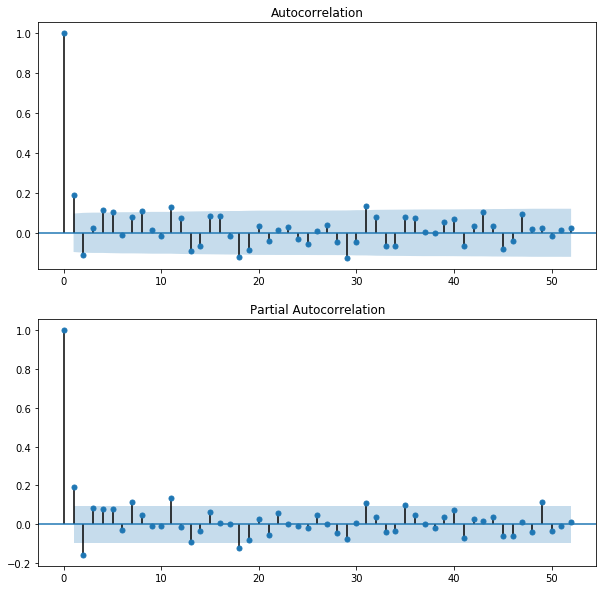

In [50]:
import statsmodels.api as sm
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_data['D_1(price)'], lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_data['D_1(price)'], lags=52, ax=ax2)

# Fitting ARIMA

In [51]:
model = auto_arima(np.array(train_data['D_1(price)']), start_p=1, start_q=1, start_P=1, start_Q=1,
                  max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                  stepwise=True, suppress_warnings=True, D=10, max_D=10,
                  error_action='ignore')
model.fit(np.array(train_data['D_1(price)']))

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 0, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [52]:
model.order

(1, 0, 1)

In [53]:
#We chose our parameters 
model_1 = ARIMA(train_data['D_1(price)'], order=model.order)
model_fit = model_1.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             D_1(price)   No. Observations:                  413
Model:                     ARMA(1, 1)   Log Likelihood                 682.626
Method:                       css-mle   S.D. of innovations              0.046
Date:                Fri, 04 Oct 2019   AIC                          -1357.251
Time:                        11:38:03   BIC                          -1341.157
Sample:                             0   HQIC                         -1350.886
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0054      0.003      2.024      0.044       0.000       0.011
ar.L1.D_1(price)    -0.4054      0.173     -2.342      0.020      -0.745      -0.066
ma.L1.D_1(price)     0.6418 

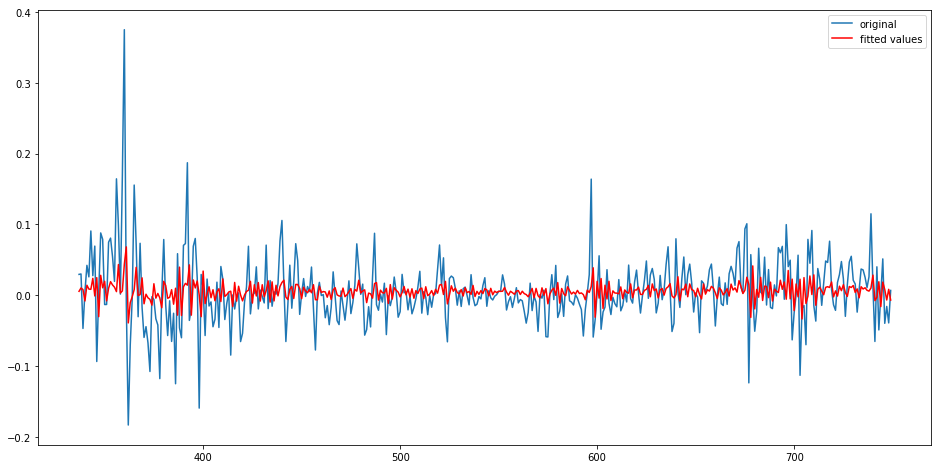

In [54]:
model_2 = ARIMA(train_data['D_1(price)'], order=(1, 0, 1))
results_AR = model_2.fit(disp=0)  
plt.figure(figsize=(16,8))
plt.plot(train_data['D_1(price)'], label='original')
plt.plot(results_AR.fittedvalues, color='red', label='fitted values')
plt.legend(loc='best')
plt.show()

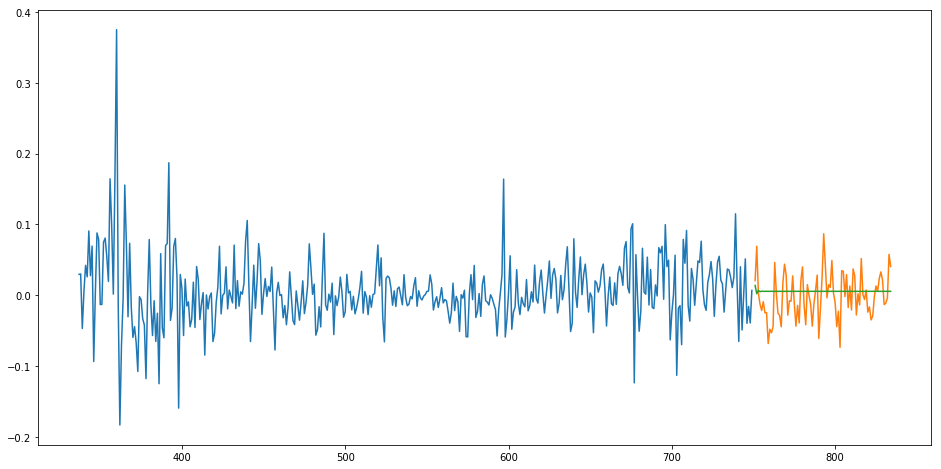

In [55]:
forecast = model.predict(n_periods=len(test_data['D_1(price)']))
forecast = pd.DataFrame(forecast,index = test_data['D_1(price)'].index,columns=['Prediction'])

#plot the predictions for validation set
plt.figure(figsize=(16,8))
plt.plot(train_data['D_1(price)'], label='D_1(price)')
plt.plot(test_data['D_1(price)'], label='D_1(price)')
plt.plot(forecast, label='Prediction')
plt.show()